In [1]:
module TSPShapley

using LinearAlgebra
using Combinatorics
using Random
using Plots
gr()

export TSG, DEPOT, visualize

const DEPOT = [0.0, 0.0]

struct TSG
    points::Array{Float64, 2}
end

function visualize(game)
    f = plot(size=(500, 500), aspect=:equal)
    scatter!(f, [DEPOT[1]], [DEPOT[2]], color=:red, label=nothing)
    scatter!(f, game.points[:, 1], game.points[:, 2], color=:blue, marker=:rect, label=nothing)
    f
end


"""
    naive computation of the Shapley values of the given TSG
"""
function appro(game; max_trial=10)
    n = size(game.points, 1)
    values = zeros(n)
    
    # distance matrix
    Ddepot = zeros(n)
    D = zeros(n, n)
    for i in 1:n
        Ddepot[i] = norm(DEPOT .- game.points[i, :])
    end
    for i in 1:n, j in i+1:n
        D[i, j] = D[j, i] = norm(game.points[i, :] .- game.points[j, :])
    end
    
    # cache of TSP
    cacheTSP = Dict()
    cacheTSP[[]] = 0.0
    function solve_tsp(N)
        if !haskey(cacheTSP, N)
            if length(N) == 1
                cacheTSP[N] = 2 * Ddepot[N[1]]
            else
                mincost = Inf
                for perm in permutations(N)
                    cost = 0.0
                    for i in 1:length(perm) - 1
                        cost += D[perm[i], perm[i + 1]]
                    end
                    cost += Ddepot[perm[1]]
                    cost += Ddepot[perm[end]]
                    if mincost > cost
                        mincost = cost
                    end
                end
                cacheTSP[N] = mincost
            end
        end
        cacheTSP[N]
    end
    
    # random
    # mm = min(factorial(n), max_trial)
    for i in 1:n
        for _ in 1:max_trial
            πi = randperm(n)
            j = findfirst(k -> k == i, πi)
            Sj = sort(πi[1:j-1])
            Sj1 = sort(πi[1:j])
            cj = solve_tsp(Sj)
            cj1 = solve_tsp(Sj1)
            term1 = (cj1 - cj) / max_trial
            values[i] += (cj1 - cj) / max_trial
        end
    end
    values
end


"""
    naive computation of the Shapley values of the given TSG
"""
function naive(game)
    n = size(game.points, 1)
    values = zeros(n)
    
    # distance matrix
    Ddepot = zeros(n)
    D = zeros(n, n)
    for i in 1:n
        Ddepot[i] = norm(DEPOT .- game.points[i, :])
    end
    for i in 1:n, j in i+1:n
        D[i, j] = D[j, i] = norm(game.points[i, :] .- game.points[j, :])
    end
    
    # cost pre-processing for all subsets on {1,...,n}
    dictcost = Dict()
    dictcost[[]] = 0.0
    for N in powerset(collect(1:n), 1)
        if length(N) == 1
            dictcost[N] = 2 * Ddepot[N[1]]
        else
            mincost = Inf
            for perm in permutations(N)
                cost = 0.0
                for i in 1:length(perm) - 1
                    cost += D[perm[i], perm[i + 1]]
                end
                cost += Ddepot[perm[1]]
                cost += Ddepot[perm[end]]
                if mincost > cost
                    mincost = cost
                end
            end
            dictcost[N] = mincost
        end
    end
    
    # computation
    for i in 1:n
        Ns = [j for j in 1:n if j != i]
        valuei = 0.0
        for S in powerset(Ns)
            Si = sort([S; i])
            c1 = dictcost[Si]
            c2 = dictcost[S]
            valuei += factorial(length(S)) * factorial(n - length(S) - 1) / factorial(n) * (c1 - c2)
        end
        values[i] = valuei
    end
    values
end


"""
    naive computation of the Shapley values of the given TSG
"""
function fast_with_sc(game)
    n = size(game.points, 1)
    values = zeros(n)
    
    # distance matrix
    Ddepot = zeros(n)
    D = zeros(n, n)
    for i in 1:n
        Ddepot[i] = norm(DEPOT .- game.points[i, :])
    end
    for i in 1:n, j in i+1:n
        D[i, j] = D[j, i] = norm(game.points[i, :] .- game.points[j, :])
    end
    
    S = zeros(n, n)
    for i in 1:n, j in i:n
        S[i, j] = S[j, i] = Ddepot[i] + Ddepot[j] - D[i, j]
    end
    
    for k in 1:n
        values[k] = S[k, k]
        vv = [S[j, k] for j in 1:n if j != k]
        sort!(vv, rev=true)
        sc = 0.0
        for l in 1:length(vv)
            sc += vv[l] / (l * (l + 1))
        end
        values[k] -= sc
    end
    values
end


end


using Main.TSPShapley
using Plots
import LinearAlgebra: norm
gr()

Plots.GRBackend()

Run

In [2]:
results_time = Dict(
    :naive => [],
    :approxO1 => [],
    :appro => [],
    :appro10 => []
)
results_diff = Dict(
    :approxO1 => [],
    :appro => [],
    :appro10 => []
)
max_trial = 50
trial = 30

30

In [3]:
for n in range(2, 10; step=1)
    logs = Float64[0.0, 0.0, 0.0]
    logs_time = Float64[0.0, 0.0, 0.0, 0.0]
    
    for _ in 1:trial
        locs = rand(n, 2) .* 10
        game = TSPShapley.TSG(locs)

        ts = time()
        res_naive = TSPShapley.naive(game)
        t1 = time() - ts
        
        ts = time()
        res_approxO1 = TSPShapley.fast_with_sc(game)
        t2 = time() - ts
        
        ts = time()
        res_appro = TSPShapley.appro(game; max_trial=max_trial)
        t3 = time() - ts
        
        ts = time()
        res_appro2 = TSPShapley.appro(game; max_trial=10 * max_trial)
        t4 = time() - ts


        diff1 = norm(res_naive .- res_approxO1)
        diff2 = norm(res_naive .- res_appro)
        diff3 = norm(res_naive .- res_appro2)
        
        logs[1] += diff1 / trial
        logs[2] += diff2 / trial
        logs[3] += diff3 / trial
        
        logs_time[1] += t1 / trial
        logs_time[2] += t2 / trial
        logs_time[3] += t3 / trial
        logs_time[4] += t4 / trial
    end
    
    # approx.
    push!(results_diff[:approxO1], logs[1])
    push!(results_diff[:appro], logs[2])
    push!(results_diff[:appro10], logs[3])
    
    # time
    push!(results_time[:naive], logs_time[1])
    push!(results_time[:approxO1], logs_time[2])
    push!(results_time[:appro], logs_time[3])
    push!(results_time[:appro10], logs_time[4])
end

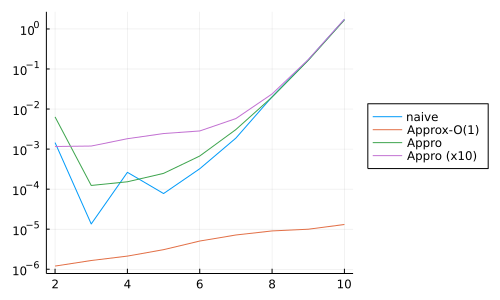

In [8]:
f = plot(yscale=:log, legend=:outerright, size=(500, 300))
xseq = 2:10
plot!(f, xseq, results_time[:naive], label="naive")
plot!(f, xseq, results_time[:approxO1], label="Approx-O(1)")
plot!(f, xseq, results_time[:appro], label="Appro")
plot!(f, xseq, results_time[:appro10], label="Appro (x10)")
savefig(f, "time.png")
f

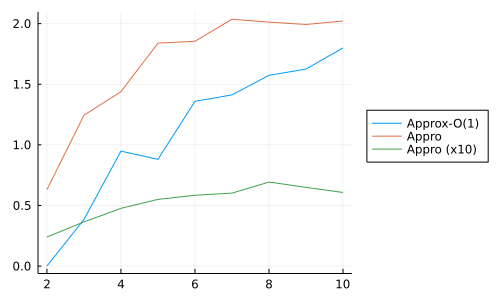

In [9]:
f = plot(legend=:outerright, size=(500, 300))
plot!(f, xseq, results_diff[:approxO1], label="Approx-O(1)")
plot!(f, xseq, results_diff[:appro], label="Appro")
plot!(f, xseq, results_diff[:appro10], label="Appro (x10)")
savefig(f, "approx.png")
f

In [6]:
for n in range(11, 20; step=1)
    lt = 0.0
    lv = 0.0
    for _ in 1:trial
        locs = rand(n, 2) .* 10
        game = TSPShapley.TSG(locs)

        ts = time()
        res_approxO1 = TSPShapley.fast_with_sc(game)
        t2 = time() - ts
        lt += t2 / trial
        lv += sum(res_approxO1) / n / trial
    end
    println("$n, $lt, $lv")
end

11, 1.1984507242838538e-5, 3.28569317877759
12, 1.1881192525227863e-5, 3.1303065089238022
13, 1.2826919555664062e-5, 2.8862476904676475
14, 1.4098485310872397e-5, 2.7529948345904582
15, 1.6045570373535156e-5, 2.615465276595779
16, 2.1672248840332026e-5, 2.546503009675212
17, 2.0829836527506512e-5, 2.3724011470446347
18, 2.3794174194335933e-5, 2.2495631476146354
19, 2.4493535359700514e-5, 2.1647954134171155
20, 3.04857889811198e-5, 2.1329009206450316
